# Using natural language processing to improve multiple choice question design

How do students solve multiple choice questions? Even if a student knows the answer, a question can be difficult to read. The question might be long or use hard-to-read jargon, or the answers might be very similar, hindering the student’s ability to compare them. How can teachers design multiple choice questions that probe students’ knowledge, without unduly taxing students’ ability to solve complex word problems?

In this document, I will use text-based analyses to determine what features of multiple choice questions are difficult for students on exams. There are three main components of my planned analysis. 

1) <a href='#lda_model'>**Latent Dirichlet Topic modeling**</a>: Identify different semantic question categories (e.g, “memory”, “language”, “perception”, etc.). <br>
2) <a href='#nlp'>**Natural Language Processing (NLP) analyses**</a>: Quantify different text properties like length of questions, word frequency in English language, etc.

In this notebook, I'll be using **(1)** and **(2)** to design features of questions that predict performance. 

3) **Mixed effects models in R**: Separately in R, I will compare these predictors and identify features diagnostic of question performance. Given a novel exam, the resulting fitted mixed effects model will allow instructors to identify what questions are worded in ways that will be difficult for students.

**6/24/2016**-Due to restrictions on making exams public, for the time being I am making this code public but not any data. I'm looking into getting permission to make exams public but for now I created a fake exam to demonstrate how this code works

First let's load our packages

In [43]:
%matplotlib inline
import os
import re
import pandas as pd
import numpy as np
import scipy as sp

from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
sw=stopwords.words('english')
valid_characters = string.ascii_letters + string.digits+string.whitespace

import seaborn as sns
sns.set_style("whitegrid")

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

Load corpus--Warning, this is kinda slow

In [2]:
from nltk.corpus import brown
freq_distr=FreqDist([word.lower() for word in  brown.words()])

<a id='dataload'></a>
# 0) Load and process exams

First let's load our exams. "exams_data.csv" contains information about where the exams are located and what classes they were for

In [3]:
exam_data=pd.read_csv('exams_data.csv')

In [4]:
exam_data.head()

,subject,class,exam,instructor
0,cognitive psychology,example_class,example_exam,tflew


So the first exam was from a fake cognitive psychology course taught by me. This directs the code to folders containing files for each exam. For example, the files for "example_exam" are located in tests/example_class/example_exam (tests/[class name]/[test name]).

Each folder contains three files. The text of the test itself is in **final.txt**. The answer key is in **final_answers.txt** and the students' responses are in **final_responses.xls** (TAs in our department tend to save these as Excel files using the Remark system)

In [39]:
data_fold='tests'

all_subject=exam_data.subject
all_instructor=exam_data.instructor
all_tests=[]
all_anskey=[]
all_resp=[]

for ind,curr_test in enumerate(exam_data.iterrows()):
    class_name=curr_test[1]['class']
    exam_name = curr_test[1]['exam']
    test_fold= os.path.join(data_fold,class_name,exam_name)

    # load test
    test_fname=os.path.join(test_fold,exam_name+'.txt')
    with open(test_fname,'rb') as test_txt:
        test=test_txt.readlines()
        all_tests.append(test)
    
    # load answer key
    anskey_fname=os.path.join(test_fold,exam_name+'_answers'+'.csv')
    all_anskey.append(pd.read_csv(anskey_fname))
    
    # load student responses
    xls_fname=os.path.join(test_fold,exam_name+'_responses'+'.xls')
    resp=pd.read_excel(xls_fname)

    # create unique random student ID. UCSD's psych grading system uses the last 4 digits of students' ID
    resp.loc[:,'Last4_ID']=[str(ind)+'_'+str(i) for i in range(len(resp)) ] 
    all_resp.append(resp)


## Text processing and test schema

And now let's figure out what are the questions and answers.

Currently, my code assumes each questions is a number followed by a period ("1. ") and each answer is lowercase letter followed by a parentheses ( "a) "). Also, lines are split by **\r, because I converted from MS Word**. If exams have a different format, you'll have to adjust the test_key and curr_test.split('\r') sections.

txt2schema() figures out the questions and answers and melts them into a dataframe

In [6]:
def txt2schema(curr_test):
    curr_test=curr_test.split('\r') 
    test_key={'question':'[\d]+\. [a-zA-Z]*','answer':'[abcde]\)','question_num':'[\d]+'}

    all_q_num=[]
    all_question=[]
    all_answer=[]
    for line in curr_test:
        # check if question
        q_search=re.findall(test_key['question'],line)
        is_q=len(q_search)==1

        # check if answer
        a_search=re.findall(test_key['answer'],line)
        is_a=len(a_search)==1

        if is_q:
            q_num=re.findall(test_key['question_num'],line)[0]
            curr_question=line[3:]
        elif is_a:
            all_q_num.append(q_num)
            all_question.append(curr_question)
            all_answer.append(line[3:])
    test_schema=pd.DataFrame({'q_num':all_q_num,'question':all_question,'answer':all_answer})
    return test_schema

And **process_text()** stems words in the questions and answers to help our NLP analyses later on. For example, if one answer uses the word "neuroscience" and another uses the word "neural", we would want to recognize those answers are similar

In [7]:
def process_text(txt):
    # get rid of punctuation
    txt=''.join([i for i in txt if i in valid_characters])
    
    # split into words
    txt_split=txt.lower().decode('latin-1').split(' ')
    
    # remove stopwords
    txt_split=[i for i in txt_split if (not (i in sw))]
    
    # create stemmer to stem words
    stemmer=SnowballStemmer("english")
    proc_text = ' '.join([stemmer.stem(i) for i in txt_split])
    return proc_text

And now I'm going to save all of our results from each exam to a single dataframe. This dataframe will store all of our processed data as I move forward

In [8]:
all_schema=pd.DataFrame({})

for ind,(curr_test,curr_subj,curr_instructor) in enumerate(zip(all_tests,all_subject,all_instructor)):
    curr_test_text=curr_test[0]
    curr_schema=txt2schema(curr_test_text)
    curr_schema.loc[:,'proc_question']=curr_schema.loc[:,'question'].apply(process_text)  
    curr_schema.loc[:,'proc_answer']=curr_schema.loc[:,'answer'].apply(process_text)  
    curr_schema.loc[:,'exam']=str(ind) # give each exam a unique id
    curr_schema.loc[:,'subject']=curr_subj
    curr_schema.loc[:,'instructor']=curr_instructor
    all_schema=all_schema.append(curr_schema)

In [9]:
all_schema.head()

,answer,q_num,question,proc_question,proc_answer,exam,subject,instructor
0,Working memory capacity is limited,1,Change detection demonstrates,chang detect demonstr,work memori capac limit,0,cognitive psychology,tflew
1,Long term memory capacity is limited,1,Change detection demonstrates,chang detect demonstr,long term memori capac limit,0,cognitive psychology,tflew
2,People are lazy,1,Change detection demonstrates,chang detect demonstr,peopl lazi,0,cognitive psychology,tflew
3,Remembering scenes is easy,1,Change detection demonstrates,chang detect demonstr,rememb scene easi,0,cognitive psychology,tflew
4,Sensation is our representation of raw stimuli...,2,The difference between sensation and perceptio...,differ sensat percept,sensat represent raw stimuli percept process r...,0,cognitive psychology,tflew


## Map questions to responses 

Now let's combine our answer key with the student responses so we can figure out students' performance on each question

In [16]:
def remove_q(txt):
    return txt[1:]

def lower_txt(txt):
    try:
        return txt.lower()
    except:
        return txt

all_resp_ans=pd.DataFrame({})
for ind,(curr_resp,curr_ans) in enumerate(zip(all_resp,all_anskey)):
    # Get responses
    curr_exam=all_schema.loc[all_schema.exam==str(ind),:]
    num_q=max([int(i) for i in np.unique(curr_exam.q_num)])
    curr_resp=all_resp[ind].iloc[:,1:(1+num_q+1)]
    curr_id=all_resp[ind].iloc[:,-1]
    curr_resp.loc[:,'Last4_ID']=curr_id
    curr_resp_melt=pd.melt(curr_resp, id_vars=['Last4_ID'])

    curr_resp_melt.loc[:,'variable']=curr_resp_melt.loc[:,'variable'].apply(remove_q)
    curr_resp_melt.loc[:,'value']=curr_resp_melt.loc[:,'value'].apply(lower_txt)
    curr_resp_melt.loc[:,'exam']=str(ind)
    curr_resp_melt.columns=['Last4_ID','q_num','response','exam']    
    
    # Get answers
    curr_answer=curr_ans.loc[:,['q_num','answer']]
    curr_answer.loc[:,'q_num']=curr_answer.loc[:,'q_num'].apply(str)
    
    # Merge the responses and answers
    curr_resp=pd.merge(curr_resp_melt,curr_answer,on='q_num')
    curr_resp.loc[:,'correct']=curr_resp.loc[:,'response']==curr_resp.loc[:,'answer']

    all_resp_ans=all_resp_ans.append(curr_resp)

In [17]:
all_resp_ans.head()

,Last4_ID,q_num,response,exam,answer,correct
0,0_0,1,b,0,a,False
1,0_1,1,a,0,a,True
2,0_2,1,a,0,a,True
3,0_3,1,b,0,a,False
4,0_4,1,a,0,a,True


<a id='lda_model'></a>
# 1) Topic modeling

And now let's try to figure out the topics of the questions using Latent Dirichlet allocation modeling.

This is a function takes a fitted LDA and returns a dataframe with the top n features from each topic

In [40]:
def get_top_features(lda_model,tf_feature_names,n,verbose=False):
    features_weights=lda_model.components_
    top_features={}
    for w_i,weights in enumerate(features_weights):
        
        best_features=[]
        ranks=len(weights)-sp.stats.rankdata(weights)
        for best in range(n):
            feature=tf_feature_names[np.where(ranks==best)[0][0]]
            best_features.append(feature)
        if verbose:
            print 'Component '+str(w_i)
            print ' ,'.join(best_features)
        top_features['Component '+str(w_i)]=best_features
    top_features_df=pd.DataFrame(top_features).transpose()
    top_features_df.loc[:,'topic']=range(len(features_weights))
    return top_features_df

#top_features=get_top_features(lda_model,tf_feature_names,10)   

And two helper functions. concat_txt() combines the question and all the answers into a singles string that the LDA can infer the topic from.

In [41]:
def concat_txt(txt):
    return ' '.join(txt)

This for-loop does the heavy lifting. It iterates over each subject and runs the topic model on the items aggregated from all the exams from that subject.

In [48]:
unique_subjects=np.unique(all_subject)

# get all exams from current subject
all_labeled=pd.DataFrame({})
all_topic=pd.DataFrame({})
for subject in unique_subjects:
    print 'Fitting '+subject
    
    # Iterate over all exams for this subject
    subject_schema=all_schema.loc[all_schema.subject==subject,:]
    ind_ans=subject_schema.loc[:,['exam', 'q_num','proc_answer']].groupby(['exam', 'q_num']).aggregate({'proc_answer':concat_txt}).reset_index()
    ind_qs=subject_schema.loc[:,['exam','q_num', 'proc_question']].drop_duplicates().reset_index()
    ind_item=pd.merge(ind_qs,ind_ans,on=['exam','q_num'])
    ind_item.loc[:,'item']=ind_item.proc_question+' '+ind_item.proc_answer
            
#     # Fit count vectorizer-Finds frequent words and 
#     n_features=25
#     tf_vectorizer = CountVectorizer(min_df=2, max_features=n_features,stop_words='english')

    # Use Tf-Idf frequency. Words that are frequent (tf) but not in a lot of documents (idf)
    tf_vectorizer=TfidfVectorizer(stop_words='english')
    
    tf = tf_vectorizer.fit_transform(ind_item.item)
    
    # Fit LDA on all test
    lda_model=LatentDirichletAllocation(n_topics=4)
    lda_model.fit(tf);
    tf_feature_names = tf_vectorizer.get_feature_names()
    top_features=get_top_features(lda_model,tf_feature_names,10,verbose=True)  
    top_features.loc[:,'subject']=subject
    top_features.loc[:,'subject_topic']=[subject+'_'+str(t) for t in range(len(top_features))]    
    top_features.reset_index(inplace=True)
    all_topic=all_topic.append(top_features)
    
    # And predict topic
    ind_item.loc[:,'topic']=[subject+'_'+str(np.argmax(items))  for items in lda_model.transform(tf)]
    all_labeled=all_labeled.append(ind_item)

Fitting cognitive psychology
Component 0
peopl ,dress ,color ,differ ,limit ,memori ,capac ,make ,decis ,avers
Component 1
languag ,sensat ,percept ,process ,represent ,object ,prime ,domin ,visual ,item
Component 2
bias ,reli ,heurist ,decis ,make ,quick ,primarili ,depth ,learn ,right
Component 3
area ,damag ,inabl ,reflect ,broca ,wernick ,fusiform ,produc ,sentenc ,face


all_topic is a dataframe containing our topics and the diagnostic words

In [49]:
all_topic.head()

,index,0,1,2,3,4,5,6,7,8,9,topic,subject,subject_topic
0,Component 0,peopl,dress,color,differ,limit,memori,capac,make,decis,avers,0,cognitive psychology,cognitive psychology_0
1,Component 1,languag,sensat,percept,process,represent,object,prime,domin,visual,item,1,cognitive psychology,cognitive psychology_1
2,Component 2,bias,reli,heurist,decis,make,quick,primarili,depth,learn,right,2,cognitive psychology,cognitive psychology_2
3,Component 3,area,damag,inabl,reflect,broca,wernick,fusiform,produc,sentenc,face,3,cognitive psychology,cognitive psychology_3


When interpretting the results of the LDA, note that the model interprets each question as arising from a mixture of possible of topic. Here I've just chosen to assign each item to its most likely topic (there might be some fun analyses to do looking at the difficulty of cross-topic questions). Each topic in turn is composed of common words with different weights. In all_topic, I've arranged the top ten words from most (0) to least (9) important. 

And we can add the topic labels to our main all_schema dataframe

In [50]:
all_schema=pd.merge(all_schema,all_labeled.loc[:,['q_num','exam','topic']],on=['q_num','exam'])

And let's get an idea of how frequently questions in each topic occur

In [51]:
all_schema.loc[:,['topic','q_num','exam']].drop_duplicates().groupby('topic').size()

topic
cognitive psychology_0    3
cognitive psychology_1    3
cognitive psychology_2    1
cognitive psychology_3    1
dtype: int64

## Analysis: Did difficulty vary by topic?

And let's see if we've done anything of significance--did students have more difficulty with certain topics?

In [18]:
resp_topic=pd.merge(all_resp_ans,all_schema.loc[:,['exam','q_num','topic']],on=['q_num','exam'])
topic_performance=resp_topic.loc[:,['topic','correct']].groupby('topic').mean().reset_index()

In [19]:
topic_results=pd.merge(top_features,topic_performance,left_on='subject_topic', right_on='topic').sort_values('correct',ascending=False)
topic_results.drop(['topic_x','subject', 'subject_topic'],axis=1,inplace=True)
topic_results

,index,0,1,2,3,4,5,6,7,8,9,topic_y,correct
0,Component 0,differ,peopl,reflect,languag,demonstr,process,rememb,decis,make,memori,cognitive psychology_0,0.078431
1,Component 2,languag,memori,demonstr,process,rememb,reflect,peopl,differ,make,decis,cognitive psychology_2,0.045752
2,Component 3,peopl,make,decis,process,differ,rememb,demonstr,reflect,languag,memori,cognitive psychology_3,0.026144


<a id='nlp'></a>
# 2) NLP analyses

Since we have our data processed and tagged, let's start creating some more complex features from our text. Coming up we've got:

a) <a href='#s_a'>Question length</a>  <br />
b) <a href='#s_b'>Answer length</a>  <br />
c) <a href='#s_c'>English word frequency</a>  <br />
d) <a href='#s_d'><a href='#s_a'>All/None of the above questions</a>  <br />
e) <a href='#s_e'>Similarity of answers to each other</a>  <br />
f) <a href='#s_f'>Similarity of the answers to the question</a>  <br />

<a id='s_a'></a>
## a) Question length

Did the length of questions affect their difficulty?

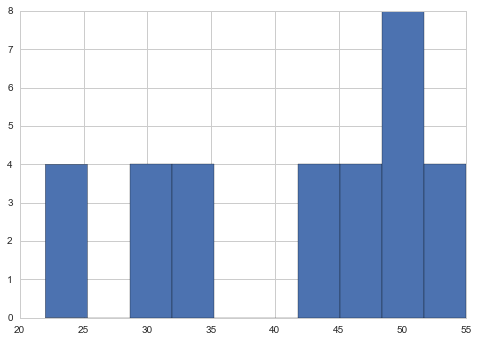

In [20]:
all_schema.loc[:,'q_len']=all_schema.loc[:,'question'].apply(len)
all_schema.loc[:,'q_len'].hist()

<a id='s_b'></a>
## b) Answer length

Did the length of answers affect students' performance?

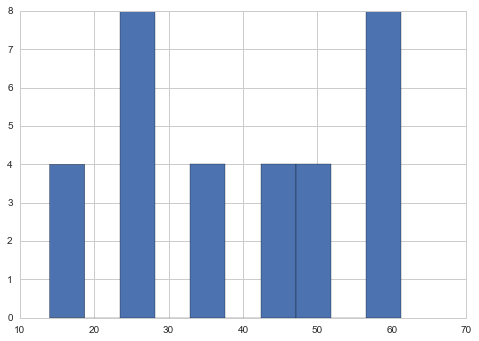

In [21]:
all_schema.loc[:,'ans_len']=all_schema.loc[:,'answer'].apply(len)
ans_len=all_schema.loc[:,['exam', 'q_num','ans_len']].groupby(['exam', 'q_num']).mean().reset_index() # average answer length
all_schema=all_schema.drop('ans_len',axis=1)
all_schema=pd.merge(all_schema,ans_len,on=['exam', 'q_num'])
all_schema.loc[:,'ans_len'].hist()

<a id='s_c'></a>
## c) English word frequency

Did infrequency and/or jargony words hurt students?

In [22]:
def get_word_freq(txt):
    txt=[t.lower() for t in txt.split(' ') if not (t in sw) ]
    freq=[freq_distr[t]+1 for t in txt]
    return np.mean(np.log10(freq))

In [23]:
get_word_freq('How now brown cow?')

1.7232199139484699

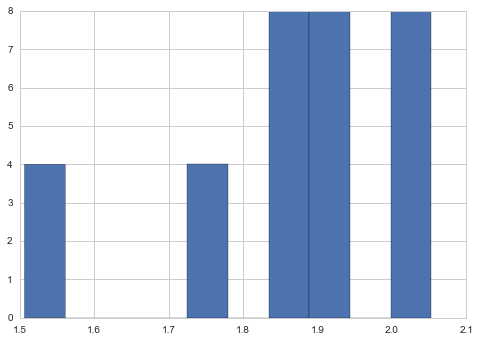

In [24]:
item_combined=all_schema.loc[:,['exam', 'q_num','answer']].groupby(['exam', 'q_num']).aggregate(concat_txt).reset_index()
temp=pd.merge(item_combined,all_schema.loc[:,['exam', 'q_num','question']],on=['exam', 'q_num'],how='left')
temp.loc[:,'all_words']=temp.loc[:,'question'] +' '+temp.loc[:,'answer']

concat_answer=temp # need later

temp.loc[:,'log_freq']=temp.loc[:,'all_words'].apply(get_word_freq)
#curr_schema_topic=pd.merge(curr_schema_topic,ind_item.loc[:,['q_num','log_freq']],on='q_num')
temp.drop_duplicates(inplace=True)
all_schema=pd.merge(all_schema,temp.loc[:,['exam', 'q_num','log_freq']],on=['exam', 'q_num'])

all_schema.loc[:,'log_freq'].hist()

<a id='s_d'></a>
# d) All/None of the above

All and none of the above questions may require some difficult logical processing from students

In [25]:
def contains_above(txt):
    txt=' '.join([i.lower() for i in txt])
    if 'all of the above' in txt or 'none of the above' in txt:
        return True
    else:
        return False

In [26]:
the_above=all_schema.loc[:,['exam','q_num','answer']].groupby(['exam','q_num']).aggregate(contains_above).reset_index()
the_above.columns=['exam','q_num','the_above']
all_schema=pd.merge(all_schema,the_above,on=['exam', 'q_num'])

In [27]:
all_schema.the_above.mean()

0.25

<a id='s_e'></a>
## e) Answer-Answer Similarity

Similar answers could have helped students by reducing the scope of possibilities they had to consider or acting as reminders or they could have hurt students by presenting virtually indistinguishable options.

The compare_text() function calculates, between two units of text, what proportion of words were shared (normalize by shorter text)?

In [28]:
def compare_text(txt1,txt2):
    txt1_words=[w.lower() for w in str(txt1).split(' ')]
    txt2_words=[w.lower() for w in str(txt2).split(' ')]    
    min_len=min([len(txt1_words),len(txt2_words)])
    if len(txt1_words)<len(txt2_words):
        min_words=txt1_words
        comp_words=txt2_words
    else:
        min_words=txt2_words        
        comp_words=txt1_words
    count=0
    for w in min_words:
        if w in comp_words:
            count=count+1

    return count/float(min_len)

In [29]:
compare_text('hello','hello world')

1.0

In [30]:
def calc_sim_aa(group_df):
    group_df.reset_index(inplace=True,drop=True)
    curr_sim=[]
    for i in range(len(group_df)):
        for j in range(len(group_df)):
            if i != j:

                item_1=group_df[i]
                item_2=group_df[j] 
                sim_prop=compare_text(item_1,item_2)
                curr_sim.append(sim_prop)

                
    return np.mean(curr_sim)   

aa_sim=all_schema.loc[:,['proc_answer','exam','q_num']].groupby(['exam','q_num']).aggregate(calc_sim_aa).reset_index()
aa_sim.columns=['exam','q_num','aa_sim']
all_schema.loc[:,'aa_sim']=pd.merge(all_schema,aa_sim,on=['exam','q_num'])

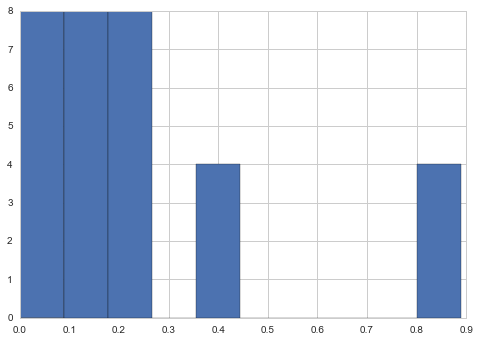

In [31]:
all_schema.loc[:,'aa_sim'].hist()    

<a id='s_f'></a>
## f) Question-Answer similarity

Likewise, questions that contained information about their answers could have contained clues for students 

In [32]:
def calc_sim_qa(group_df):
    group_df.reset_index(inplace=True,drop=True)
    curr_sim=[]
    for i in range(len(group_df)):

        item_1=group_df.proc_answer[i]
        item_2=group_df.proc_question[i] 
        sim_prop=compare_text(item_1,item_2)
        curr_sim.append(sim_prop)
                
    return np.mean(curr_sim)   

for e in np.unique(all_schema.exam):
    curr_q=np.unique(all_schema.loc[all_schema.exam==e,'q_num'])
    for q in curr_q:
        sel_ind=np.logical_and(all_schema.exam==e,all_schema.q_num==q)
        curr_qs=all_schema.loc[sel_ind,:]
        all_schema.loc[sel_ind,'qa_sim']=calc_sim_qa(curr_qs)

In [33]:
for e in np.unique(all_schema.exam):
    curr_q=np.unique(all_schema.loc[all_schema.exam==e,'q_num'])
    for q in curr_q:
        sel_ind=np.logical_and(all_schema.exam==e,all_schema.q_num==q)
        curr_qs=all_schema.loc[sel_ind,:]
        all_schema.loc[sel_ind,'qa_sim']=calc_sim_qa(curr_qs)

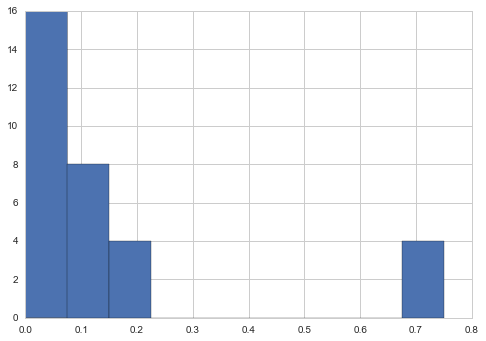

In [34]:
all_schema.loc[:,'qa_sim'].hist()  

# Wrapping up: Combine data for lmer in R

And after all that, we've assembled a good number of features to predict students' performance on exams

In [35]:
fields_to_transfer=['q_num','topic','q_len','ans_len','log_freq','the_above', 'aa_sim','qa_sim','subject','instructor']
mc_test_data=pd.merge(all_resp_ans,all_schema.loc[:,fields_to_transfer])
mc_test_data=mc_test_data.groupby([ 'Last4_ID','subject','instructor','q_num','topic','answer']).mean().reset_index()
mc_test_data.head()

,Last4_ID,subject,instructor,q_num,topic,answer,correct,q_len,ans_len,log_freq,the_above,aa_sim,qa_sim
0,0_0,cognitive psychology,tflew,1,cognitive psychology_2,a,False,29,27.75,1.868999,False,0.125000,0.000000
1,0_0,cognitive psychology,tflew,2,cognitive psychology_3,a,True,50,61.25,1.506331,False,0.888889,0.750000
2,0_0,cognitive psychology,tflew,3,cognitive psychology_0,b,True,55,14.00,1.904348,False,0.250000,0.000000
3,0_0,cognitive psychology,tflew,4,cognitive psychology_2,a,True,46,57.25,2.053145,False,0.000000,0.083333
4,0_0,cognitive psychology,tflew,5,cognitive psychology_0,a,True,45,26.25,2.010838,True,0.083333,0.112500


Finally, let's save our results

In [37]:
mc_test_data.to_csv('exam_processed.csv')

And now we can go ahead and use this csv in R to find what factors predict people's performance!

We'll want to use **lmer()** to build our model, gradually adding features, and **anova()** to check whether those features explain more of the variance. I looked around for a mixed effects model in Python, and there is some for in the statsmodel package, but it's limited a single random effect.